<a href="https://colab.research.google.com/github/hhduke2014/marked-beetle-analysis/blob/main/0825efficientnet_B7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import glob
import shutil
import json
import keras
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter
from keras.preprocessing.image import ImageDataGenerator

import cv2
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
filenames = os.listdir("/content/drive/MyDrive/MarkedBeetleImageAnalysis")
filenames[1]


'PaperedControl21v_light.tif'

In [4]:
train_images=[]
for filename in filenames:
    if 'light' not in filename:
      if filename.startswith('Papered') or filename.startswith('NoPapered'):
        train_images.append(filename)
print(f"Number of Train images: {len(train_images)}") #filename.startswith('Pink')

Number of Train images: 757


In [5]:
categories = []
for filename in train_images:
    if filename.startswith('Papered') or filename.startswith('Pink') or filename.startswith('Trap'):
        categories.append('marked')
    if filename.startswith('NoPapered'):
        categories.append('unmarked')
len(categories)

757

In [6]:
df = pd.DataFrame({
    'filename': train_images,
    'category': categories
})
df

,filename,category
0,PaperedControl21d.tif,marked
1,PaperedControl22v.tif,marked
2,PaperedControl22d.tif,marked
3,PaperedControl23v.tif,marked
4,PaperedControl23d.tif,marked
...,...,...
752,PaperedControl19v.tif,marked
753,PaperedControl19d.tif,marked
754,PaperedControl20v.tif,marked
755,PaperedControl20d.tif,marked


In [9]:
df['category'].value_counts()

marked      479
unmarked    278
Name: category, dtype: int64

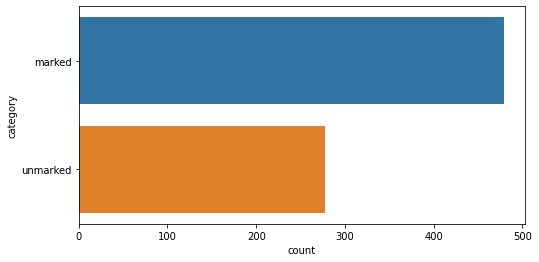

In [10]:
plt.figure(figsize=(8, 4))
sns.countplot(y="category", data=df);

In [11]:
image = cv2.imread(os.path.join("/content/drive/MyDrive/MarkedBeetleImageAnalysis", filenames[1]))
image.shape

(1944, 2592, 3)

In [12]:
def visualize_batch(image_ids, labels):
    plt.figure(figsize=(16, 12))
    for ind, (image_id, label) in enumerate(zip(image_ids, labels)):
        plt.subplot(3, 3, ind+1 )
        image = cv2.imread(os.path.join("/content/drive/MyDrive/MarkedBeetleImageAnalysis", image_id))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        plt.imshow(image)
        plt.title(f"{label}", fontsize=12)
        plt.axis("off")
    
    plt.show()

In [13]:
tmp_df = df.sample(9)
tmp_df

,filename,category
175,PaperedTransparent29d.tif,marked
705,PaperedControl5v.tif,marked
543,NoPaperedMixed29d.tif,unmarked
238,PaperedTransparent61v.tif,marked
88,PaperedControl65v.tif,marked
560,NoPaperedMixed38v.tif,unmarked
147,PaperedTransparent15v.tif,marked
398,NoPaperedGreen42v.tif,unmarked
576,NoPaperedMixed46v.tif,unmarked


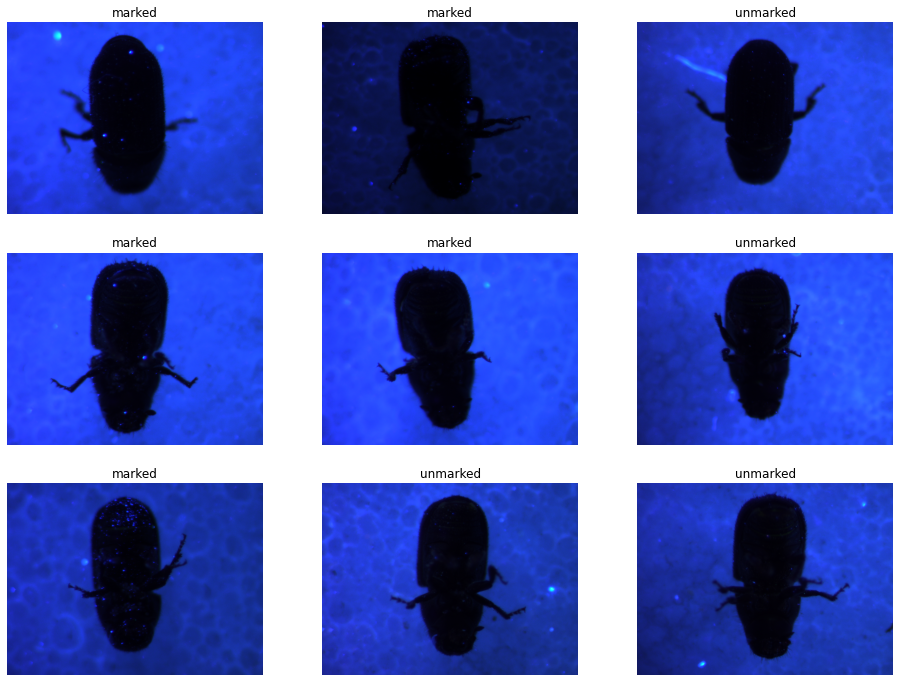

In [14]:
image_ids = tmp_df["filename"].values
labels = tmp_df["category"].values

visualize_batch(image_ids, labels)

In [ ]:
#df["category"] = df["category"].replace({0: 'NotMarked', 1: 'Marked'}) 

In [15]:
train_df, validate_df = train_test_split(df, test_size = 0.10, random_state = 42, stratify = df['category'])
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

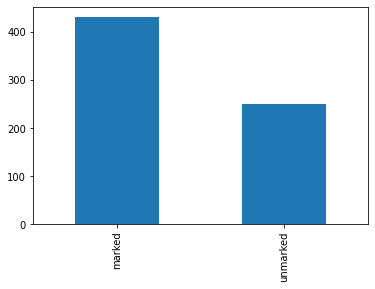

In [16]:
train_df['category'].value_counts().plot.bar()

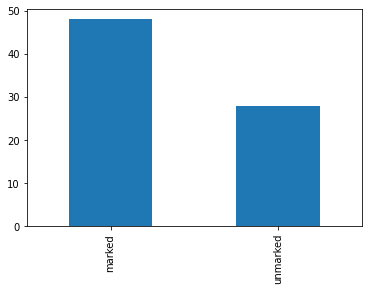

In [17]:
validate_df['category'].value_counts().plot.bar()

In [18]:
IMG_SIZE = 600
size = (IMG_SIZE,IMG_SIZE)
n_CLASS = 2
BATCH_SIZE = 15

In [19]:
datagen_train = ImageDataGenerator(
                    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
                    rotation_range = 40,
                    width_shift_range = 0.2,
                    height_shift_range = 0.2,
                    shear_range = 0.2,
                    zoom_range = 0.2,
                    horizontal_flip = True,
                    vertical_flip = True,
                    fill_mode = 'nearest')

In [20]:
datagen_val = ImageDataGenerator(
                    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
                    )

In [21]:
train_set = datagen_train.flow_from_dataframe(train_df,
                             directory = "/content/drive/MyDrive/MarkedBeetleImageAnalysis",
                             seed=42,
                             x_col = 'filename',
                             y_col = 'category',
                             target_size = size,
                             #color_mode="rgb",
                             class_mode = 'categorical',
                             interpolation = 'nearest',
                             shuffle = True,
                             batch_size = BATCH_SIZE)

Found 681 validated image filenames belonging to 2 classes.


In [22]:
validate_set = datagen_val.flow_from_dataframe(validate_df,
                             directory = "/content/drive/MyDrive/MarkedBeetleImageAnalysis",
                             seed=42,
                             x_col = 'filename',
                             y_col = 'category',
                             target_size = size,
                             #color_mode="rgb",
                             class_mode = 'categorical',
                             interpolation = 'nearest',
                             shuffle = True,
                             batch_size = BATCH_SIZE)

Found 76 validated image filenames belonging to 2 classes.


In [ ]:
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D, Flatten, Dense, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import RMSprop, Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras import layers

def create_model():
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    model = EfficientNetB7(include_top=False, input_tensor=inputs, weights="imagenet")
    #model = EfficientNetB7(input_shape = (IMG_SIZE, IMG_SIZE, 3), include_top = False,
                            # weights = 'imagenet',
                             #drop_connect_rate=0.6)
    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.Flatten()(x)
    x = layers.BatchNormalization()(x)

    x = layers.Dense(256, activation = 'relu', bias_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.001))(x)

    top_dropout_rate = 0.5
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(2, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    return model

model = create_model()
model.summary()

In [24]:
EPOCHS = 50
STEP_SIZE_TRAIN = train_set.n//train_set.batch_size
STEP_SIZE_VALID = validate_set.n//validate_set.batch_size

In [25]:
def Model_fit():
    
    #leaf_model = None
    
    model = create_model()
    
    '''Compiling the model'''
    
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits = False,
                                                   label_smoothing=0.0001,
                                                   name='categorical_crossentropy' )
    
    model.compile(optimizer = Adam(learning_rate = 1e-3),
                        loss = loss, #'categorical_crossentropy'
                        metrics = ['accuracy']) #'acc'
    
        # Stop training when the val_loss has stopped decreasing for 3 epochs.
    stop = EarlyStopping(monitor='val_loss', mode='min', patience=3,
                       restore_best_weights=True, verbose=1)
    
    # Save the model with the minimum validation loss
    checkpoint_cb = ModelCheckpoint("25efficientnetB7_model.h5",
                                    save_best_only=True,
                                    monitor = 'val_loss',
                                    mode='min')
    
    # reduce learning rate
    reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                                  factor = 0.2,
                                  patience = 2,
                                  min_lr = 1e-6,
                                  mode = 'min',
                                  verbose = 1)
    history = model.fit(train_set,
                             validation_data = validate_set,
                             epochs= EPOCHS,
                             batch_size = BATCH_SIZE,
                             #class_weight = d_class_weights,
                             steps_per_epoch = STEP_SIZE_TRAIN,
                             validation_steps = STEP_SIZE_VALID,
                             callbacks=[stop, checkpoint_cb, reduce_lr])
    model.save('model'+'.h5')  
    return history

In [26]:
results = Model_fit()

Epoch 1/50
45/45 [==============================] - 1012s 21s/step - loss: 1.0948 - accuracy: 0.7613 - val_loss: 0.4281 - val_accuracy: 0.7733


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50
45/45 [==============================] - 364s 8s/step - loss: 1.1447 - accuracy: 0.7703 - val_loss: 0.5101 - val_accuracy: 0.6933
Epoch 3/50
45/45 [==============================] - 350s 8s/step - loss: 0.8194 - accuracy: 0.8093 - val_loss: 0.3146 - val_accuracy: 0.8533
Epoch 4/50
45/45 [==============================] - 346s 8s/step - loss: 0.7109 - accuracy: 0.8393 - val_loss: 0.2913 - val_accuracy: 0.8667
Epoch 5/50
45/45 [==============================] - 345s 8s/step - loss: 0.5744 - accuracy: 0.8258 - val_loss: 0.2953 - val_accuracy: 0.8400
Epoch 6/50
45/45 [==============================] - 343s 8s/step - loss: 0.6891 - accuracy: 0.8438 - val_loss: 0.3528 - val_accuracy: 0.8533

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 7/50
45/45 [==============================] - 339s 8s/step - loss: 0.5264 - accuracy: 0.8468 - val_loss: 0.2505 - val_accuracy: 0.9200
Epoch 8/50
45/45 [==============================] - 344s 8s/step - loss:

In [27]:
print('Train_Cat-Acc: ', max(results.history['accuracy']))
print('Val_Cat-Acc: ', max(results.history['val_accuracy']))

Train_Cat-Acc:  0.8828828930854797
Val_Cat-Acc:  0.9333333373069763


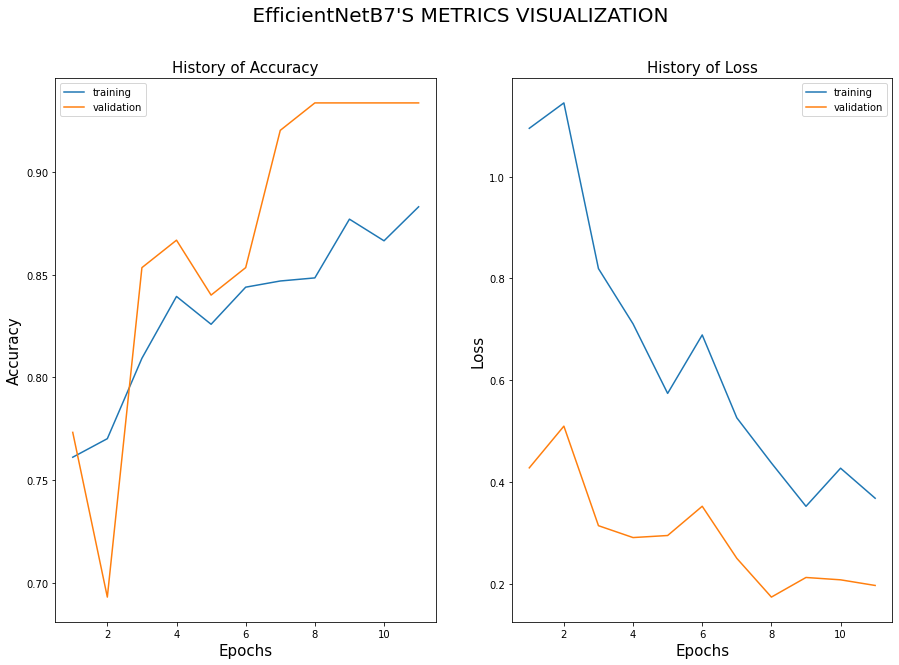

In [28]:
def Train_Val_Plot(acc,val_acc,loss,val_loss):
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize= (15,10))
    fig.suptitle(" EfficientNetB7'S METRICS VISUALIZATION ", fontsize=20)

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy', fontsize=15)
    ax1.set_xlabel('Epochs', fontsize=15)
    ax1.set_ylabel('Accuracy', fontsize=15)
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss', fontsize=15)
    ax2.set_xlabel('Epochs', fontsize=15)
    ax2.set_ylabel('Loss', fontsize=15)
    ax2.legend(['training', 'validation'])
    plt.show()
    

Train_Val_Plot(results.history['accuracy'],results.history['val_accuracy'],
               results.history['loss'],results.history['val_loss'])

In [29]:
import keras

final_model = keras.models.load_model('25efficientnetB7_model.h5')

**Testing on training set**

In [30]:
nb_samples1 = train_df.shape[0]

In [31]:
test_gen = ImageDataGenerator(preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
                    #rotation_range = 40,
                    #brightness_range = [0.3,0.9],
                    #channel_shift_range = 50.0,
                    #width_shift_range = 0.2,
                    #height_shift_range = 0.2,
                    #shear_range = 0.2,
                    #zoom_range = 0.2,
                    #horizontal_flip = True,
                    #vertical_flip = True,
                    #fill_mode = 'nearest'
                    )
test_generator = test_gen.flow_from_dataframe(
     train_df, 
    "/content/drive/MyDrive/MarkedBeetleImageAnalysis/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=size,
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 681 validated image filenames.


In [32]:
predictdf = final_model.predict(test_generator, steps=np.ceil(nb_samples1/BATCH_SIZE))

In [33]:
train_df['prediction'] = np.argmax(predictdf, axis=-1)
train_df["prediction"] = train_df["prediction"].replace({1: 'unmarked', 0: 'marked'}) 
train_df

,filename,category,prediction
0,NoPaperedGreen45d.tif,unmarked,marked
1,PaperedControl54d.tif,marked,marked
2,PaperedMixed24v.tif,marked,marked
3,NoPaperedMixed10d.tif,unmarked,unmarked
4,PaperedTransparent51d.tif,marked,marked
...,...,...,...
676,NoPaperedGreen76d.tif,unmarked,marked
677,PaperedControl29v.tif,marked,marked
678,PaperedTransparent47v.tif,marked,marked
679,PaperedMixed46d.tif,marked,marked


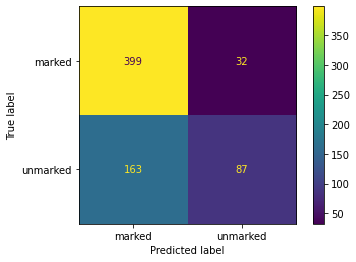

In [34]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_true=list(train_df['category'])
y_pred=list(train_df['prediction'])
cm1=confusion_matrix(y_true, y_pred, labels=["marked", "unmarked"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm1, display_labels=["marked", "unmarked"])
disp.plot(values_format="d")

**Testing on validation set**

In [35]:
to_samples = validate_df.shape[0]

In [36]:
test_gen = ImageDataGenerator(preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
                    #rotation_range = 40,
                    #brightness_range = [0.3,0.9],
                    #channel_shift_range = 50.0,
                    #width_shift_range = 0.2,
                    #height_shift_range = 0.2,
                    #shear_range = 0.2,
                    #zoom_range = 0.2,
                    #horizontal_flip = True,
                    #vertical_flip = True,
                    #fill_mode = 'nearest'
                    )
test_generator1 = test_gen.flow_from_dataframe(
    validate_df, 
    "/content/drive/MyDrive/MarkedBeetleImageAnalysis/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=size,
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 76 validated image filenames.


In [37]:
predict = final_model.predict(test_generator1, steps=np.ceil(to_samples/BATCH_SIZE))
predict

array([[3.03249568e-01, 6.96750462e-01],
       [9.44782972e-01, 5.52170053e-02],
       [4.13805008e-01, 5.86194992e-01],
       [8.99391472e-01, 1.00608498e-01],
       [3.85933697e-01, 6.14066243e-01],
       [3.10920954e-01, 6.89079046e-01],
       [9.99999881e-01, 1.04275919e-07],
       [4.21679676e-01, 5.78320324e-01],
       [9.92906094e-01, 7.09391898e-03],
       [5.78952134e-01, 4.21047896e-01],
       [7.11651206e-01, 2.88348764e-01],
       [9.25506532e-01, 7.44934902e-02],
       [1.88101202e-01, 8.11898768e-01],
       [9.96000350e-01, 3.99961136e-03],
       [6.21697664e-01, 3.78302366e-01],
       [8.72689009e-01, 1.27310961e-01],
       [5.51688433e-01, 4.48311597e-01],
       [8.93038034e-01, 1.06962033e-01],
       [3.58621597e-01, 6.41378403e-01],
       [9.97868419e-01, 2.13156571e-03],
       [4.70818400e-01, 5.29181600e-01],
       [3.91035169e-01, 6.08964801e-01],
       [9.09902036e-01, 9.00979638e-02],
       [2.78766960e-01, 7.21233010e-01],
       [8.777622

In [38]:
validate_df['prediction'] = np.argmax(predict, axis=1)
validate_df["prediction"] = validate_df["prediction"].replace({1: 'unmarked', 0: 'marked'}) 
validate_df

,filename,category,prediction
0,PaperedTransparent88d.tif,marked,unmarked
1,PaperedTransparent36d.tif,marked,marked
2,PaperedTransparent29v.tif,marked,unmarked
3,NoPaperedGreen20d.tif,unmarked,marked
4,NoPaperedGreen58d.tif,unmarked,unmarked
...,...,...,...
71,PaperedControl48v.tif,marked,marked
72,PaperedTransparent77v.tif,marked,marked
73,NoPaperedGreen84v.tif,unmarked,marked
74,PaperedMixed38d.tif,marked,marked


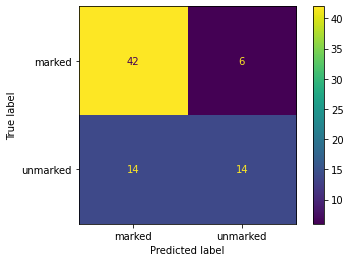

In [39]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_true=list(validate_df['category'])
y_pred=list(validate_df['prediction'])
cm=confusion_matrix(y_true, y_pred, labels=["marked", "unmarked"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["marked", "unmarked"])
disp.plot(values_format="d")

**Other way of prediction**

In [ ]:
preds=[]
for image_id in tmp_df1.filename:
  image = Image.open(os.path.join("/content/drive/MyDrive/MarkedBeetleImageAnalysis/",image_id))
  image = image.resize(size)
  image = np.expand_dims(image,axis=0)
  preds.append(np.argmax(final_model.predict(image)))
tmp_df1["prediction"]=preds

In [ ]:
tmp_df1["prediction"] = tmp_df1["prediction"].replace({1: 'unmarked', 0: 'marked'}) 
tmp_df1

,filename,category,prediction
594,NoPaperedMixed35v.tif,unmarked,marked
405,NoPaperedGreen22v.tif,unmarked,unmarked
655,PaperedMixed15d.tif,marked,marked
34,PaperedControl33d.tif,marked,marked
708,PaperedMixed42d.tif,marked,marked
363,PaperedTransparent104v.tif,marked,marked
516,NoPaperedGreen82v.tif,unmarked,unmarked
323,PaperedTransparent84v.tif,marked,marked
266,PaperedTransparent57v.tif,marked,marked
478,NoPaperedGreen62v.tif,unmarked,unmarked
